In [1]:
import math
import os
import pickle
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from torch.utils.data import DataLoader
from torchvision import datasets
from tqdm import tqdm

from efficient_kan.kan import KAN
from kan_convolutional import KANLinear
from kan_convolutional.KANConv import KAN_Convolutional_Layer
from torchkan.KANvolver import KANvolver as kanv

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# TRAININGSET + TESTSET DEFINITION

In [23]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# Train set. Here we sort the MNIST by digits and disable data shuffling
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
sorted_indices = sorted(range(len(train_dataset) // 8), key=lambda idx: train_dataset.targets[idx])
train_subset = torch.utils.data.Subset(train_dataset, sorted_indices)
train_loader = DataLoader(train_subset, batch_size=64, shuffle=False)

# MultiTask training sets
train_loader_tasks = []
indices=[]
for k in range(5):
    indices.append(list(
        filter(lambda idx: train_dataset.targets[idx] in range(k * 2, k * 2 + 2), range(len(train_dataset)))))
    train_loader_tasks.append(
        DataLoader(torch.utils.data.Subset(train_dataset, indices[-1]), batch_size=64, shuffle=True))

# Test set
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_subset = torch.utils.data.Subset(test_dataset, range(len(test_dataset) // 4))
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)


# ARCHITECTURES DEFINITION

In [3]:
# MLP
class MLP(nn.Module):
    def __init__(self, checkpoint: str | None = None):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 28 * 28)
        self.fc2 = nn.Linear(28 * 28, 256)
        self.fc3 = nn.Linear(256, 10)
        if checkpoint:
            self.load_state_dict(torch.load(checkpoint))
            self.eval()

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
# KAN
class KAN_small(nn.Module):
    def __init__(self, device=device, checkpoint: str | None = None):
        super(KAN_small, self).__init__()
        self.model = KAN([28 * 28, 128, 10]).to(device)
        if checkpoint:
            self.load_state_dict(torch.load(checkpoint))
            self.eval()

    def forward(self, x):
        return self.model(x)


class KAN_big(nn.Module):
    def __init__(self, device=device):
        super(KAN_big, self).__init__()
        self.model = KAN([28 * 28, 28 * 28, 128, 10]).to(device)

    def forward(self, x):
        return self.model(x)

In [5]:
# KAN_Convolutional_Layer + MLP
class CKAN_BN(nn.Module):
    def __init__(self, device: str = device):
        super().__init__()
        self.conv1 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )
        self.bn1 = nn.BatchNorm2d(5)

        self.conv2 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )
        self.bn2 = nn.BatchNorm2d(25)

        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )

        self.flat = nn.Flatten()

        self.linear1 = nn.Linear(625, 256)
        self.linear2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x = self.pool1(x)
        x = self.flat(x)
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [6]:
# KAN_Convolutional_Layer + MLP (without Batch Norm)
class KANC_MLP(nn.Module):
    def __init__(self, device: str = device):
        super().__init__()
        self.conv1 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )

        self.conv2 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )

        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )

        self.flat = nn.Flatten()

        self.linear1 = nn.Linear(625, 256)
        self.linear2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)

        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool1(x)
        x = self.flat(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [7]:
# Conv2d + KAN
class NormalConvsKAN(nn.Module):
    def __init__(self):
        super(NormalConvsKAN, self).__init__()
        # Convolutional layer, assuming an input with 1 channel (grayscale image)
        # and producing 16 output channels, with a kernel size of 3x3
        self.conv1 = nn.Conv2d(1, 5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(5, 5, kernel_size=3, padding=1)

        # Max pooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=2)

        # Flatten layer
        self.flatten = nn.Flatten()

        # KAN layer
        self.kan1 = KANLinear(
            245,
            10,
            grid_size=10,
            spline_order=3,
            scale_noise=0.01,
            scale_base=1,
            scale_spline=1,
            base_activation=nn.SiLU,
            grid_eps=0.02,
            grid_range=[0, 1])

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.kan1(x)
        x = F.log_softmax(x, dim=1)

        return x

In [8]:
# Conv2d + MLP + (Dropout)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding='same')
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding='same')

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding='same')

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)
        self.dropout3 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        #x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)
        #x = self.dropout2(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        #x = self.dropout3(x)
        x = self.fc2(x)

        #x = F.log_softmax(x, dim=1)
        return x

In [9]:
# KAN_Convolutional_Layer + KAN
class KKAN_Convolutional_Network(nn.Module):
    def __init__(self, device: str = device):
        super().__init__()
        self.conv1 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )

        self.conv2 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )

        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )

        self.flat = nn.Flatten()

        self.kan1 = KANLinear(
            625,
            10,
            grid_size=10,
            spline_order=3,
            scale_noise=0.01,
            scale_base=1,
            scale_spline=1,
            base_activation=nn.SiLU,
            grid_eps=0.02,
            grid_range=[0, 1],
        )

    def forward(self, x):
        x = self.conv1(x)

        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool1(x)
        x = self.flat(x)

        x = self.kan1(x)
        x = F.log_softmax(x, dim=1)

        return x

In [10]:
# Conv2d + MLP
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(5, 5, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2)

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(245, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)

        return x

In [11]:
# KANvolver
class KANvolver(nn.Module):
    def __init__(self, device=device, checkpoint: str | None = None):
        super(KANvolver, self).__init__()
        self.model = kanv([10]).to(device)
        if checkpoint:
            self.load_state_dict(torch.load(checkpoint))
            self.eval()

    def forward(self, x):
        return self.model(x)

# TRAIN() AND TEST() FUNCTIONS

In [25]:
def train(model, checkpoint, optimizer, start_epoch=0, epochs=5, on_epoch_end=None, lr=0, loader=train_loader,
          task_id=None):
    criterion = nn.CrossEntropyLoss()
    # scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.996)
    for epoch in range(start_epoch, epochs + start_epoch):
        model.train()
        losses = []
        accuracies = []
        epoch_start = time.time_ns()
        with tqdm(loader) as pbar:
            for i, (images, labels) in enumerate(pbar):
                if model.__class__.__name__ in ['MLP', 'KAN_small', 'KAN_big']:
                    images = images.view(-1, 28 * 28)
                optimizer.zero_grad()
                output = model(images.to(device))
                loss = criterion(output, labels.to(device))
                loss.backward()
                optimizer.step(closure=lambda: loss)
                accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
                pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])
                losses.append(loss.item())
                accuracies.append(accuracy.item())
                # scheduler.step()
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')
        epoch_duration = (time.time_ns() - epoch_start) // 1000000
        if on_epoch_end is not None:
            on_epoch_end(model, epoch, losses, accuracies, epoch_duration, lr, task_id)
        # torch.save(model.state_dict(), f'{checkpoint}_ep{epoch + 1}.pth')

In [13]:
def test(model):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    predictions = []
    ground_truths = []
    val_accuracy = 0
    loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            if model.__class__.__name__ in ['MLP', 'KAN_small', 'KAN_big']:
                images = images.view(-1, 28 * 28)
            output = model(images.to(device))
            loss = criterion(output, labels.to(device))
            predictions.extend(output.argmax(dim=1).to('cpu').numpy())
            ground_truths.extend(labels.to('cpu').numpy())
            val_accuracy += (output.argmax(dim=1) == labels.to(device)).float().mean().item()
    val_accuracy /= len(test_loader)
    print(f"Accuracy: {val_accuracy}")
    return loss.item(), ground_truths, predictions

# INTRA and INTER DATASET TESTS

In [14]:
class EpochStat:
    @staticmethod
    def loadModelStats(name, dir='checkpoint_intra/stats/', subdir='') -> list['EpochStat']:
        return sorted([pickle.load(open(f'{dir}{subdir}{file}', 'rb')) for file in
                       filter(lambda e: name == '_'.join(e.split('_')[:-1]), os.listdir(f'{dir}{subdir}'))],
                      key=lambda e: e.epoch)
        # return [pickle.load(open(f'{dir}{subdir}{file}', 'rb')) for file in
        #         filter(lambda e: name == '_'.join(e.split('_')[:-1]), os.listdir(f'{dir}{subdir}'))]

    def __init__(self, name, epoch, train_loss=0, test_loss=0, labels=None, predictions=None, epoch_duration=0, lr=0,
                 train_losses=None, train_accuracies=None, task_id=None):
        self.name = name
        self.train_loss = train_loss
        self.test_loss = test_loss
        self.epoch = epoch
        self.predictions = predictions
        self.labels = labels
        self.epoch_duration = epoch_duration
        self.lr = lr
        self.train_losses = train_losses
        self.train_accuracies = train_accuracies
        self.task_id = task_id

    def save(self, dir='checkpoint_intra/stats/'):
        os.makedirs(dir, exist_ok=True)
        pickle.dump(self, open(f'{dir}{self.name}_epoch{self.epoch}.pickle', 'wb'))

    def get_accuracy(self):
        accuracy = 0
        for label, prediction in zip(self.labels, self.predictions):
            if label == prediction:
                accuracy += 1
        return accuracy / len(self.labels)


def onEpochEnd(model, epoch, train_losses, train_accuracies, epoch_duration, lr, task_id):
    test_loss, labels, predictions = test(model)
    stat = EpochStat(model.__class__.__name__, epoch, train_losses[-1], test_loss, labels, predictions, epoch_duration,
                     lr, train_losses, train_accuracies, task_id)
    stat.save(
        dir=f'checkpoint_intra/stats/lr_{round(math.log10(lr))}/' if task_id is None else f'checkpoint_inter/stats/lr_{round(math.log10(lr))}/')

## INTRA DATASET TEST

In [26]:
for lr in [1e-3,1e-4, 1e-5, 1e-6, 1e-7][2:3]:
    models = [MLP(), KAN_small(),
              CKAN_BN(), KANC_MLP(), NormalConvsKAN(), ConvNet(),
              KKAN_Convolutional_Network(), SimpleCNN(),KANvolver()]
    print(f'Using lr={lr} ------------------------------------')
    for model in [x.to(device) for x in models[2:-1]]:
        print(f'Training model={model.__class__.__name__}')
        # lr = 1e-5 if model.__class__.__name__ in ['MLP', 'KAN_small', 'KAN_big'] else 1e-4
        train(model, f'checkpoint_intra/{model.__class__.__name__}', epochs=30, start_epoch=0,
              optimizer=optim.Adam(model.parameters(), lr=lr), on_epoch_end=onEpochEnd, lr=lr)

Using lr=1e-05 ------------------------------------
Training model=CKAN_BN


100%|██████████| 118/118 [00:18<00:00,  6.43it/s, accuracy=0, loss=2.42, lr=1e-5]     


Epoch 1, Loss: 2.4200689792633057
Accuracy: 0.187890625


100%|██████████| 118/118 [00:18<00:00,  6.36it/s, accuracy=0.417, loss=2.16, lr=1e-5] 


Epoch 2, Loss: 2.1571266651153564
Accuracy: 0.299609375


100%|██████████| 118/118 [00:19<00:00,  6.18it/s, accuracy=0.5, loss=1.98, lr=1e-5]   


Epoch 3, Loss: 1.9828141927719116
Accuracy: 0.41015625


100%|██████████| 118/118 [00:18<00:00,  6.22it/s, accuracy=0.583, loss=1.86, lr=1e-5] 


Epoch 4, Loss: 1.857656478881836
Accuracy: 0.49921875


100%|██████████| 118/118 [00:18<00:00,  6.24it/s, accuracy=0.583, loss=1.76, lr=1e-5]


Epoch 5, Loss: 1.7597671747207642
Accuracy: 0.551171875


100%|██████████| 118/118 [00:19<00:00,  6.15it/s, accuracy=0.667, loss=1.68, lr=1e-5]


Epoch 6, Loss: 1.6775351762771606
Accuracy: 0.5875


100%|██████████| 118/118 [00:19<00:00,  6.12it/s, accuracy=0.75, loss=1.6, lr=1e-5]  


Epoch 7, Loss: 1.6049561500549316
Accuracy: 0.625


100%|██████████| 118/118 [00:19<00:00,  6.11it/s, accuracy=0.75, loss=1.54, lr=1e-5] 


Epoch 8, Loss: 1.5388833284378052
Accuracy: 0.646484375


100%|██████████| 118/118 [00:19<00:00,  6.13it/s, accuracy=0.75, loss=1.48, lr=1e-5] 


Epoch 9, Loss: 1.4776302576065063
Accuracy: 0.664453125


100%|██████████| 118/118 [00:19<00:00,  6.18it/s, accuracy=0.75, loss=1.42, lr=1e-5] 


Epoch 10, Loss: 1.4202500581741333
Accuracy: 0.68125


100%|██████████| 118/118 [00:19<00:00,  5.91it/s, accuracy=0.75, loss=1.37, lr=1e-5] 


Epoch 11, Loss: 1.3662773370742798
Accuracy: 0.69609375


100%|██████████| 118/118 [00:19<00:00,  6.18it/s, accuracy=0.75, loss=1.32, lr=1e-5] 


Epoch 12, Loss: 1.3153820037841797
Accuracy: 0.70625


100%|██████████| 118/118 [00:19<00:00,  6.05it/s, accuracy=0.75, loss=1.27, lr=1e-5] 


Epoch 13, Loss: 1.2673176527023315
Accuracy: 0.7140625


100%|██████████| 118/118 [00:19<00:00,  5.98it/s, accuracy=0.833, loss=1.22, lr=1e-5]


Epoch 14, Loss: 1.2218886613845825
Accuracy: 0.721484375


100%|██████████| 118/118 [00:19<00:00,  5.99it/s, accuracy=0.917, loss=1.18, lr=1e-5]


Epoch 15, Loss: 1.1789342164993286
Accuracy: 0.73203125


100%|██████████| 118/118 [00:19<00:00,  6.09it/s, accuracy=0.917, loss=1.14, lr=1e-5]


Epoch 16, Loss: 1.1382979154586792
Accuracy: 0.7390625


100%|██████████| 118/118 [00:19<00:00,  5.92it/s, accuracy=0.917, loss=1.1, lr=1e-5] 


Epoch 17, Loss: 1.0998282432556152
Accuracy: 0.7453125


100%|██████████| 118/118 [00:19<00:00,  5.94it/s, accuracy=0.917, loss=1.06, lr=1e-5]


Epoch 18, Loss: 1.0634233951568604
Accuracy: 0.75


100%|██████████| 118/118 [00:19<00:00,  5.99it/s, accuracy=0.917, loss=1.03, lr=1e-5]


Epoch 19, Loss: 1.0290015935897827
Accuracy: 0.755078125


100%|██████████| 118/118 [00:19<00:00,  6.14it/s, accuracy=0.917, loss=0.996, lr=1e-5]


Epoch 20, Loss: 0.996417760848999
Accuracy: 0.76171875


100%|██████████| 118/118 [00:19<00:00,  5.93it/s, accuracy=0.917, loss=0.966, lr=1e-5]


Epoch 21, Loss: 0.9655407071113586
Accuracy: 0.7671875


100%|██████████| 118/118 [00:19<00:00,  5.92it/s, accuracy=0.917, loss=0.936, lr=1e-5]


Epoch 22, Loss: 0.9362691044807434
Accuracy: 0.771875


100%|██████████| 118/118 [00:20<00:00,  5.80it/s, accuracy=0.917, loss=0.908, lr=1e-5]


Epoch 23, Loss: 0.9084808230400085
Accuracy: 0.776171875


100%|██████████| 118/118 [00:19<00:00,  6.12it/s, accuracy=0.917, loss=0.882, lr=1e-5]


Epoch 24, Loss: 0.8820877075195312
Accuracy: 0.7796875


100%|██████████| 118/118 [00:19<00:00,  6.17it/s, accuracy=0.917, loss=0.857, lr=1e-5]


Epoch 25, Loss: 0.8570052981376648
Accuracy: 0.783984375


100%|██████████| 118/118 [00:18<00:00,  6.35it/s, accuracy=0.917, loss=0.833, lr=1e-5]


Epoch 26, Loss: 0.8331410884857178
Accuracy: 0.790625


100%|██████████| 118/118 [00:18<00:00,  6.40it/s, accuracy=0.917, loss=0.81, lr=1e-5] 


Epoch 27, Loss: 0.8104568123817444
Accuracy: 0.799609375


100%|██████████| 118/118 [00:18<00:00,  6.22it/s, accuracy=0.917, loss=0.789, lr=1e-5]


Epoch 28, Loss: 0.7888519763946533
Accuracy: 0.803125


100%|██████████| 118/118 [00:19<00:00,  6.19it/s, accuracy=0.917, loss=0.768, lr=1e-5]


Epoch 29, Loss: 0.7682308554649353
Accuracy: 0.804296875


100%|██████████| 118/118 [00:18<00:00,  6.25it/s, accuracy=0.917, loss=0.749, lr=1e-5]


Epoch 30, Loss: 0.7485337853431702
Accuracy: 0.81015625
Training model=KANC_MLP


100%|██████████| 118/118 [00:19<00:00,  6.17it/s, accuracy=0, loss=2.3, lr=1e-5]      


Epoch 1, Loss: 2.302065134048462
Accuracy: 0.19296875


100%|██████████| 118/118 [00:19<00:00,  6.14it/s, accuracy=0, loss=2.29, lr=1e-5]     


Epoch 2, Loss: 2.2931225299835205
Accuracy: 0.26875


100%|██████████| 118/118 [00:19<00:00,  6.13it/s, accuracy=0, loss=2.28, lr=1e-5]     


Epoch 3, Loss: 2.284318208694458
Accuracy: 0.3171875


100%|██████████| 118/118 [00:19<00:00,  5.99it/s, accuracy=0, loss=2.28, lr=1e-5]     


Epoch 4, Loss: 2.275531053543091
Accuracy: 0.35703125


100%|██████████| 118/118 [00:20<00:00,  5.89it/s, accuracy=0, loss=2.27, lr=1e-5]     


Epoch 5, Loss: 2.266627073287964
Accuracy: 0.387890625


100%|██████████| 118/118 [00:19<00:00,  6.01it/s, accuracy=0, loss=2.26, lr=1e-5]     


Epoch 6, Loss: 2.2574968338012695
Accuracy: 0.408984375


100%|██████████| 118/118 [00:19<00:00,  6.16it/s, accuracy=0, loss=2.25, lr=1e-5]     


Epoch 7, Loss: 2.248041868209839
Accuracy: 0.424609375


100%|██████████| 118/118 [00:19<00:00,  6.07it/s, accuracy=0.0833, loss=2.24, lr=1e-5]


Epoch 8, Loss: 2.2381784915924072
Accuracy: 0.443359375


100%|██████████| 118/118 [00:18<00:00,  6.34it/s, accuracy=0.167, loss=2.23, lr=1e-5] 


Epoch 9, Loss: 2.22786545753479
Accuracy: 0.4515625


100%|██████████| 118/118 [00:18<00:00,  6.43it/s, accuracy=0.167, loss=2.22, lr=1e-5] 


Epoch 10, Loss: 2.217053174972534
Accuracy: 0.463671875


100%|██████████| 118/118 [00:18<00:00,  6.37it/s, accuracy=0.167, loss=2.21, lr=1e-5] 


Epoch 11, Loss: 2.205704927444458
Accuracy: 0.476953125


100%|██████████| 118/118 [00:18<00:00,  6.31it/s, accuracy=0.167, loss=2.19, lr=1e-5] 


Epoch 12, Loss: 2.1937806606292725
Accuracy: 0.484765625


100%|██████████| 118/118 [00:18<00:00,  6.28it/s, accuracy=0.167, loss=2.18, lr=1e-5] 


Epoch 13, Loss: 2.1812429428100586
Accuracy: 0.495703125


100%|██████████| 118/118 [00:18<00:00,  6.42it/s, accuracy=0.167, loss=2.17, lr=1e-5] 


Epoch 14, Loss: 2.1680848598480225
Accuracy: 0.5015625


100%|██████████| 118/118 [00:19<00:00,  6.07it/s, accuracy=0.167, loss=2.15, lr=1e-5] 


Epoch 15, Loss: 2.154292345046997
Accuracy: 0.5109375


100%|██████████| 118/118 [00:19<00:00,  5.96it/s, accuracy=0.333, loss=2.14, lr=1e-5] 


Epoch 16, Loss: 2.139873743057251
Accuracy: 0.517578125


100%|██████████| 118/118 [00:19<00:00,  5.96it/s, accuracy=0.333, loss=2.12, lr=1e-5] 


Epoch 17, Loss: 2.124814510345459
Accuracy: 0.526953125


100%|██████████| 118/118 [00:20<00:00,  5.90it/s, accuracy=0.333, loss=2.11, lr=1e-5] 


Epoch 18, Loss: 2.109145164489746
Accuracy: 0.533203125


100%|██████████| 118/118 [00:20<00:00,  5.90it/s, accuracy=0.333, loss=2.09, lr=1e-5]


Epoch 19, Loss: 2.09287691116333
Accuracy: 0.537109375


100%|██████████| 118/118 [00:19<00:00,  5.91it/s, accuracy=0.333, loss=2.08, lr=1e-5]


Epoch 20, Loss: 2.0760176181793213
Accuracy: 0.547265625


100%|██████████| 118/118 [00:19<00:00,  5.91it/s, accuracy=0.333, loss=2.06, lr=1e-5]


Epoch 21, Loss: 2.0585854053497314
Accuracy: 0.551171875


100%|██████████| 118/118 [00:19<00:00,  5.91it/s, accuracy=0.333, loss=2.04, lr=1e-5]


Epoch 22, Loss: 2.04059100151062
Accuracy: 0.55546875


100%|██████████| 118/118 [00:20<00:00,  5.90it/s, accuracy=0.333, loss=2.02, lr=1e-5]


Epoch 23, Loss: 2.0220730304718018
Accuracy: 0.562109375


100%|██████████| 118/118 [00:20<00:00,  5.75it/s, accuracy=0.333, loss=2, lr=1e-5]   


Epoch 24, Loss: 2.0030415058135986
Accuracy: 0.569140625


100%|██████████| 118/118 [00:20<00:00,  5.87it/s, accuracy=0.417, loss=1.98, lr=1e-5]


Epoch 25, Loss: 1.9835033416748047
Accuracy: 0.576953125


100%|██████████| 118/118 [00:20<00:00,  5.86it/s, accuracy=0.417, loss=1.96, lr=1e-5]


Epoch 26, Loss: 1.9635004997253418
Accuracy: 0.58359375


100%|██████████| 118/118 [00:19<00:00,  5.91it/s, accuracy=0.417, loss=1.94, lr=1e-5]


Epoch 27, Loss: 1.9430513381958008
Accuracy: 0.589453125


100%|██████████| 118/118 [00:20<00:00,  5.85it/s, accuracy=0.417, loss=1.92, lr=1e-5]


Epoch 28, Loss: 1.9221738576889038
Accuracy: 0.6015625


100%|██████████| 118/118 [00:20<00:00,  5.80it/s, accuracy=0.417, loss=1.9, lr=1e-5] 


Epoch 29, Loss: 1.900882601737976
Accuracy: 0.60546875


100%|██████████| 118/118 [00:20<00:00,  5.78it/s, accuracy=0.417, loss=1.88, lr=1e-5]


Epoch 30, Loss: 1.8791766166687012
Accuracy: 0.6140625
Training model=NormalConvsKAN


100%|██████████| 118/118 [00:02<00:00, 43.08it/s, accuracy=0, loss=2.31, lr=1e-5]    


Epoch 1, Loss: 2.310588836669922
Accuracy: 0.091015625


100%|██████████| 118/118 [00:02<00:00, 46.40it/s, accuracy=0, loss=2.31, lr=1e-5]    


Epoch 2, Loss: 2.308354377746582
Accuracy: 0.093359375


100%|██████████| 118/118 [00:02<00:00, 47.44it/s, accuracy=0, loss=2.31, lr=1e-5]    


Epoch 3, Loss: 2.3059890270233154
Accuracy: 0.095703125


100%|██████████| 118/118 [00:02<00:00, 51.75it/s, accuracy=0, loss=2.3, lr=1e-5]     


Epoch 4, Loss: 2.3035800457000732
Accuracy: 0.099609375


100%|██████████| 118/118 [00:02<00:00, 52.19it/s, accuracy=0, loss=2.3, lr=1e-5]     


Epoch 5, Loss: 2.3011200428009033
Accuracy: 0.10390625


100%|██████████| 118/118 [00:02<00:00, 53.36it/s, accuracy=0, loss=2.3, lr=1e-5]     


Epoch 6, Loss: 2.298612117767334
Accuracy: 0.1078125


100%|██████████| 118/118 [00:02<00:00, 47.41it/s, accuracy=0, loss=2.3, lr=1e-5]     


Epoch 7, Loss: 2.2960736751556396
Accuracy: 0.112890625


100%|██████████| 118/118 [00:02<00:00, 49.54it/s, accuracy=0, loss=2.29, lr=1e-5]    


Epoch 8, Loss: 2.293492555618286
Accuracy: 0.121484375


100%|██████████| 118/118 [00:02<00:00, 48.97it/s, accuracy=0, loss=2.29, lr=1e-5]    


Epoch 9, Loss: 2.290834665298462
Accuracy: 0.131640625


100%|██████████| 118/118 [00:02<00:00, 48.76it/s, accuracy=0, loss=2.29, lr=1e-5]    


Epoch 10, Loss: 2.2880876064300537
Accuracy: 0.138671875


100%|██████████| 118/118 [00:02<00:00, 50.89it/s, accuracy=0, loss=2.29, lr=1e-5]    


Epoch 11, Loss: 2.2852728366851807
Accuracy: 0.146484375


100%|██████████| 118/118 [00:02<00:00, 48.36it/s, accuracy=0, loss=2.28, lr=1e-5]     


Epoch 12, Loss: 2.282386302947998
Accuracy: 0.155859375


100%|██████████| 118/118 [00:02<00:00, 48.63it/s, accuracy=0, loss=2.28, lr=1e-5]     


Epoch 13, Loss: 2.279409170150757
Accuracy: 0.164453125


100%|██████████| 118/118 [00:02<00:00, 51.30it/s, accuracy=0, loss=2.28, lr=1e-5]     


Epoch 14, Loss: 2.276341676712036
Accuracy: 0.1703125


100%|██████████| 118/118 [00:02<00:00, 47.94it/s, accuracy=0, loss=2.27, lr=1e-5]     


Epoch 15, Loss: 2.2731845378875732
Accuracy: 0.179296875


100%|██████████| 118/118 [00:02<00:00, 48.74it/s, accuracy=0, loss=2.27, lr=1e-5]     


Epoch 16, Loss: 2.2699391841888428
Accuracy: 0.188671875


100%|██████████| 118/118 [00:02<00:00, 49.86it/s, accuracy=0.0833, loss=2.27, lr=1e-5]


Epoch 17, Loss: 2.2666022777557373
Accuracy: 0.197265625


100%|██████████| 118/118 [00:02<00:00, 48.95it/s, accuracy=0.167, loss=2.26, lr=1e-5] 


Epoch 18, Loss: 2.2631893157958984
Accuracy: 0.20703125


100%|██████████| 118/118 [00:02<00:00, 50.23it/s, accuracy=0.25, loss=2.26, lr=1e-5]  


Epoch 19, Loss: 2.259697675704956
Accuracy: 0.21796875


100%|██████████| 118/118 [00:02<00:00, 51.54it/s, accuracy=0.333, loss=2.26, lr=1e-5] 


Epoch 20, Loss: 2.256091594696045
Accuracy: 0.228515625


100%|██████████| 118/118 [00:02<00:00, 52.88it/s, accuracy=0.333, loss=2.25, lr=1e-5] 


Epoch 21, Loss: 2.2523868083953857
Accuracy: 0.240625


100%|██████████| 118/118 [00:02<00:00, 52.42it/s, accuracy=0.333, loss=2.25, lr=1e-5] 


Epoch 22, Loss: 2.2485780715942383
Accuracy: 0.25


100%|██████████| 118/118 [00:02<00:00, 49.19it/s, accuracy=0.333, loss=2.24, lr=1e-5] 


Epoch 23, Loss: 2.2446670532226562
Accuracy: 0.264453125


100%|██████████| 118/118 [00:02<00:00, 49.86it/s, accuracy=0.333, loss=2.24, lr=1e-5] 


Epoch 24, Loss: 2.240654945373535
Accuracy: 0.28046875


100%|██████████| 118/118 [00:02<00:00, 49.74it/s, accuracy=0.333, loss=2.24, lr=1e-5] 


Epoch 25, Loss: 2.2365379333496094
Accuracy: 0.294921875


100%|██████████| 118/118 [00:02<00:00, 49.58it/s, accuracy=0.333, loss=2.23, lr=1e-5]


Epoch 26, Loss: 2.2322866916656494
Accuracy: 0.312890625


100%|██████████| 118/118 [00:02<00:00, 49.37it/s, accuracy=0.417, loss=2.23, lr=1e-5]


Epoch 27, Loss: 2.2279319763183594
Accuracy: 0.326953125


100%|██████████| 118/118 [00:02<00:00, 49.79it/s, accuracy=0.5, loss=2.22, lr=1e-5]  


Epoch 28, Loss: 2.2234885692596436
Accuracy: 0.342578125


100%|██████████| 118/118 [00:02<00:00, 49.61it/s, accuracy=0.583, loss=2.22, lr=1e-5]


Epoch 29, Loss: 2.218963861465454
Accuracy: 0.358203125


100%|██████████| 118/118 [00:02<00:00, 50.86it/s, accuracy=0.583, loss=2.21, lr=1e-5]


Epoch 30, Loss: 2.2143664360046387
Accuracy: 0.371875
Training model=ConvNet


100%|██████████| 118/118 [00:02<00:00, 52.94it/s, accuracy=0, loss=2.27, lr=1e-5]   


Epoch 1, Loss: 2.2681095600128174
Accuracy: 0.138671875


100%|██████████| 118/118 [00:02<00:00, 53.15it/s, accuracy=0, loss=2.27, lr=1e-5]    


Epoch 2, Loss: 2.267406702041626
Accuracy: 0.15078125


100%|██████████| 118/118 [00:02<00:00, 56.17it/s, accuracy=0, loss=2.27, lr=1e-5]   


Epoch 3, Loss: 2.2722854614257812
Accuracy: 0.17421875


100%|██████████| 118/118 [00:02<00:00, 55.15it/s, accuracy=0, loss=2.27, lr=1e-5]    


Epoch 4, Loss: 2.267242193222046
Accuracy: 0.216015625


100%|██████████| 118/118 [00:02<00:00, 54.34it/s, accuracy=0, loss=2.26, lr=1e-5]     


Epoch 5, Loss: 2.260432004928589
Accuracy: 0.25625


100%|██████████| 118/118 [00:02<00:00, 54.38it/s, accuracy=0, loss=2.26, lr=1e-5]     


Epoch 6, Loss: 2.26332950592041
Accuracy: 0.26328125


100%|██████████| 118/118 [00:02<00:00, 52.95it/s, accuracy=0, loss=2.26, lr=1e-5]    


Epoch 7, Loss: 2.2551748752593994
Accuracy: 0.2765625


100%|██████████| 118/118 [00:02<00:00, 57.32it/s, accuracy=0, loss=2.21, lr=1e-5]    


Epoch 8, Loss: 2.210446357727051
Accuracy: 0.3703125


100%|██████████| 118/118 [00:02<00:00, 54.89it/s, accuracy=0, loss=2.14, lr=1e-5]    


Epoch 9, Loss: 2.137829065322876
Accuracy: 0.485546875


100%|██████████| 118/118 [00:02<00:00, 58.45it/s, accuracy=0, loss=1.99, lr=1e-5]     


Epoch 10, Loss: 1.9876198768615723
Accuracy: 0.515625


100%|██████████| 118/118 [00:01<00:00, 59.04it/s, accuracy=0.25, loss=1.74, lr=1e-5]  


Epoch 11, Loss: 1.7399851083755493
Accuracy: 0.601171875


100%|██████████| 118/118 [00:02<00:00, 55.11it/s, accuracy=0.667, loss=1.44, lr=1e-5] 


Epoch 12, Loss: 1.4444125890731812
Accuracy: 0.69921875


100%|██████████| 118/118 [00:02<00:00, 45.53it/s, accuracy=0.833, loss=1.18, lr=1e-5] 


Epoch 13, Loss: 1.183510422706604
Accuracy: 0.75546875


100%|██████████| 118/118 [00:02<00:00, 56.58it/s, accuracy=0.917, loss=0.982, lr=1e-5]


Epoch 14, Loss: 0.982062578201294
Accuracy: 0.777734375


100%|██████████| 118/118 [00:02<00:00, 49.07it/s, accuracy=0.917, loss=0.86, lr=1e-5] 


Epoch 15, Loss: 0.8599724769592285
Accuracy: 0.787890625


100%|██████████| 118/118 [00:02<00:00, 57.84it/s, accuracy=0.917, loss=0.758, lr=1e-5]


Epoch 16, Loss: 0.757743775844574
Accuracy: 0.801171875


100%|██████████| 118/118 [00:02<00:00, 56.41it/s, accuracy=0.917, loss=0.683, lr=1e-5]


Epoch 17, Loss: 0.6831719875335693
Accuracy: 0.813671875


100%|██████████| 118/118 [00:02<00:00, 51.12it/s, accuracy=0.917, loss=0.624, lr=1e-5]


Epoch 18, Loss: 0.6244038343429565
Accuracy: 0.8234375


100%|██████████| 118/118 [00:02<00:00, 49.20it/s, accuracy=0.917, loss=0.578, lr=1e-5]


Epoch 19, Loss: 0.5780195593833923
Accuracy: 0.834375


100%|██████████| 118/118 [00:02<00:00, 47.41it/s, accuracy=0.917, loss=0.539, lr=1e-5]


Epoch 20, Loss: 0.5390567183494568
Accuracy: 0.84453125


100%|██████████| 118/118 [00:02<00:00, 46.15it/s, accuracy=0.917, loss=0.506, lr=1e-5]


Epoch 21, Loss: 0.5063899159431458
Accuracy: 0.853125


100%|██████████| 118/118 [00:02<00:00, 46.45it/s, accuracy=0.917, loss=0.478, lr=1e-5]


Epoch 22, Loss: 0.47810491919517517
Accuracy: 0.855859375


100%|██████████| 118/118 [00:02<00:00, 45.39it/s, accuracy=1, loss=0.461, lr=1e-5]    


Epoch 23, Loss: 0.4613598883152008
Accuracy: 0.860546875


100%|██████████| 118/118 [00:02<00:00, 42.85it/s, accuracy=1, loss=0.435, lr=1e-5]    


Epoch 24, Loss: 0.43502530455589294
Accuracy: 0.867578125


100%|██████████| 118/118 [00:02<00:00, 47.70it/s, accuracy=1, loss=0.415, lr=1e-5]    


Epoch 25, Loss: 0.4149153530597687
Accuracy: 0.87265625


100%|██████████| 118/118 [00:02<00:00, 51.62it/s, accuracy=1, loss=0.396, lr=1e-5]    


Epoch 26, Loss: 0.3960748612880707
Accuracy: 0.876171875


100%|██████████| 118/118 [00:02<00:00, 55.14it/s, accuracy=1, loss=0.379, lr=1e-5]    


Epoch 27, Loss: 0.37901750206947327
Accuracy: 0.881640625


100%|██████████| 118/118 [00:02<00:00, 50.03it/s, accuracy=1, loss=0.364, lr=1e-5]    


Epoch 28, Loss: 0.36380240321159363
Accuracy: 0.88828125


100%|██████████| 118/118 [00:02<00:00, 45.22it/s, accuracy=1, loss=0.35, lr=1e-5]     


Epoch 29, Loss: 0.34959569573402405
Accuracy: 0.891796875


100%|██████████| 118/118 [00:02<00:00, 44.68it/s, accuracy=1, loss=0.336, lr=1e-5]    


Epoch 30, Loss: 0.3355487585067749
Accuracy: 0.8953125
Training model=KKAN_Convolutional_Network


100%|██████████| 118/118 [00:19<00:00,  5.99it/s, accuracy=0, loss=2.32, lr=1e-5]     


Epoch 1, Loss: 2.3223698139190674
Accuracy: 0.10703125


100%|██████████| 118/118 [00:20<00:00,  5.89it/s, accuracy=0, loss=2.32, lr=1e-5]     


Epoch 2, Loss: 2.3205463886260986
Accuracy: 0.133984375


100%|██████████| 118/118 [00:20<00:00,  5.83it/s, accuracy=0, loss=2.32, lr=1e-5]     


Epoch 3, Loss: 2.318662166595459
Accuracy: 0.178125


100%|██████████| 118/118 [00:20<00:00,  5.87it/s, accuracy=0, loss=2.32, lr=1e-5]     


Epoch 4, Loss: 2.316758155822754
Accuracy: 0.22734375


100%|██████████| 118/118 [00:20<00:00,  5.82it/s, accuracy=0, loss=2.31, lr=1e-5]     


Epoch 5, Loss: 2.3148322105407715
Accuracy: 0.287109375


100%|██████████| 118/118 [00:20<00:00,  5.71it/s, accuracy=0, loss=2.31, lr=1e-5]     


Epoch 6, Loss: 2.312873125076294
Accuracy: 0.334375


100%|██████████| 118/118 [00:20<00:00,  5.63it/s, accuracy=0, loss=2.31, lr=1e-5]     


Epoch 7, Loss: 2.310872793197632
Accuracy: 0.369140625


100%|██████████| 118/118 [00:20<00:00,  5.75it/s, accuracy=0, loss=2.31, lr=1e-5]     


Epoch 8, Loss: 2.3088204860687256
Accuracy: 0.4140625


100%|██████████| 118/118 [00:20<00:00,  5.71it/s, accuracy=0, loss=2.31, lr=1e-5]     


Epoch 9, Loss: 2.3067057132720947
Accuracy: 0.44765625


100%|██████████| 118/118 [00:20<00:00,  5.84it/s, accuracy=0, loss=2.3, lr=1e-5]      


Epoch 10, Loss: 2.3045144081115723
Accuracy: 0.46953125


100%|██████████| 118/118 [00:20<00:00,  5.71it/s, accuracy=0, loss=2.3, lr=1e-5]     


Epoch 11, Loss: 2.3022356033325195
Accuracy: 0.484375


100%|██████████| 118/118 [00:19<00:00,  6.02it/s, accuracy=0, loss=2.3, lr=1e-5]     


Epoch 12, Loss: 2.2998595237731934
Accuracy: 0.5


100%|██████████| 118/118 [00:20<00:00,  5.87it/s, accuracy=0, loss=2.3, lr=1e-5]     


Epoch 13, Loss: 2.2973721027374268
Accuracy: 0.514453125


100%|██████████| 118/118 [00:20<00:00,  5.82it/s, accuracy=0, loss=2.29, lr=1e-5]     


Epoch 14, Loss: 2.294759511947632
Accuracy: 0.530078125


100%|██████████| 118/118 [00:19<00:00,  6.03it/s, accuracy=0, loss=2.29, lr=1e-5]     


Epoch 15, Loss: 2.29201340675354
Accuracy: 0.54140625


100%|██████████| 118/118 [00:19<00:00,  6.11it/s, accuracy=0, loss=2.29, lr=1e-5]     


Epoch 16, Loss: 2.289118528366089
Accuracy: 0.554296875


100%|██████████| 118/118 [00:19<00:00,  6.06it/s, accuracy=0, loss=2.29, lr=1e-5]     


Epoch 17, Loss: 2.2860562801361084
Accuracy: 0.562109375


100%|██████████| 118/118 [00:19<00:00,  6.06it/s, accuracy=0, loss=2.28, lr=1e-5]     


Epoch 18, Loss: 2.2828266620635986
Accuracy: 0.573046875


100%|██████████| 118/118 [00:19<00:00,  6.07it/s, accuracy=0.167, loss=2.28, lr=1e-5] 


Epoch 19, Loss: 2.2794253826141357
Accuracy: 0.584375


100%|██████████| 118/118 [00:19<00:00,  6.08it/s, accuracy=0.167, loss=2.28, lr=1e-5] 


Epoch 20, Loss: 2.275852680206299
Accuracy: 0.591796875


100%|██████████| 118/118 [00:19<00:00,  6.10it/s, accuracy=0.167, loss=2.27, lr=1e-5] 


Epoch 21, Loss: 2.272096633911133
Accuracy: 0.6015625


100%|██████████| 118/118 [00:19<00:00,  6.11it/s, accuracy=0.167, loss=2.27, lr=1e-5] 


Epoch 22, Loss: 2.268141984939575
Accuracy: 0.609765625


100%|██████████| 118/118 [00:19<00:00,  6.12it/s, accuracy=0.333, loss=2.26, lr=1e-5] 


Epoch 23, Loss: 2.2639853954315186
Accuracy: 0.61953125


100%|██████████| 118/118 [00:19<00:00,  6.13it/s, accuracy=0.417, loss=2.26, lr=1e-5] 


Epoch 24, Loss: 2.2596263885498047
Accuracy: 0.629296875


100%|██████████| 118/118 [00:19<00:00,  6.09it/s, accuracy=0.5, loss=2.26, lr=1e-5]   


Epoch 25, Loss: 2.255056381225586
Accuracy: 0.63359375


100%|██████████| 118/118 [00:19<00:00,  6.08it/s, accuracy=0.583, loss=2.25, lr=1e-5]


Epoch 26, Loss: 2.2502617835998535
Accuracy: 0.64140625


100%|██████████| 118/118 [00:19<00:00,  6.14it/s, accuracy=0.75, loss=2.25, lr=1e-5] 


Epoch 27, Loss: 2.245248556137085
Accuracy: 0.647265625


100%|██████████| 118/118 [00:19<00:00,  6.14it/s, accuracy=0.75, loss=2.24, lr=1e-5] 


Epoch 28, Loss: 2.2400248050689697
Accuracy: 0.658203125


100%|██████████| 118/118 [00:19<00:00,  6.11it/s, accuracy=0.75, loss=2.23, lr=1e-5] 


Epoch 29, Loss: 2.2345874309539795
Accuracy: 0.6625


100%|██████████| 118/118 [00:19<00:00,  6.10it/s, accuracy=0.75, loss=2.23, lr=1e-5] 


Epoch 30, Loss: 2.2289257049560547
Accuracy: 0.669140625
Training model=SimpleCNN


100%|██████████| 118/118 [00:01<00:00, 59.43it/s, accuracy=1, loss=2.01, lr=1e-5]    


Epoch 1, Loss: 2.0079352855682373
Accuracy: 0.12109375


100%|██████████| 118/118 [00:01<00:00, 59.21it/s, accuracy=1, loss=2.01, lr=1e-5]    


Epoch 2, Loss: 2.0146000385284424
Accuracy: 0.125


100%|██████████| 118/118 [00:02<00:00, 53.33it/s, accuracy=1, loss=2.02, lr=1e-5]    


Epoch 3, Loss: 2.0205271244049072
Accuracy: 0.1265625


100%|██████████| 118/118 [00:02<00:00, 56.65it/s, accuracy=1, loss=2.03, lr=1e-5]    


Epoch 4, Loss: 2.0260257720947266
Accuracy: 0.12734375


100%|██████████| 118/118 [00:02<00:00, 55.69it/s, accuracy=1, loss=2.03, lr=1e-5]    


Epoch 5, Loss: 2.031207799911499
Accuracy: 0.127734375


100%|██████████| 118/118 [00:02<00:00, 57.22it/s, accuracy=1, loss=2.04, lr=1e-5]    


Epoch 6, Loss: 2.0361223220825195
Accuracy: 0.128515625


100%|██████████| 118/118 [00:02<00:00, 56.43it/s, accuracy=1, loss=2.04, lr=1e-5]    


Epoch 7, Loss: 2.0407798290252686
Accuracy: 0.130078125


100%|██████████| 118/118 [00:02<00:00, 55.28it/s, accuracy=1, loss=2.05, lr=1e-5]    


Epoch 8, Loss: 2.0452065467834473
Accuracy: 0.13125


100%|██████████| 118/118 [00:02<00:00, 56.83it/s, accuracy=1, loss=2.05, lr=1e-5]    


Epoch 9, Loss: 2.049428939819336
Accuracy: 0.132421875


100%|██████████| 118/118 [00:02<00:00, 56.11it/s, accuracy=1, loss=2.05, lr=1e-5]    


Epoch 10, Loss: 2.053440570831299
Accuracy: 0.133984375


100%|██████████| 118/118 [00:02<00:00, 55.15it/s, accuracy=1, loss=2.06, lr=1e-5]    


Epoch 11, Loss: 2.0572729110717773
Accuracy: 0.136328125


100%|██████████| 118/118 [00:02<00:00, 56.54it/s, accuracy=1, loss=2.06, lr=1e-5]    


Epoch 12, Loss: 2.0609352588653564
Accuracy: 0.138671875


100%|██████████| 118/118 [00:02<00:00, 56.14it/s, accuracy=1, loss=2.06, lr=1e-5]    


Epoch 13, Loss: 2.064483404159546
Accuracy: 0.138671875


100%|██████████| 118/118 [00:02<00:00, 57.06it/s, accuracy=1, loss=2.07, lr=1e-5]    


Epoch 14, Loss: 2.067864179611206
Accuracy: 0.13984375


100%|██████████| 118/118 [00:02<00:00, 56.58it/s, accuracy=1, loss=2.07, lr=1e-5]    


Epoch 15, Loss: 2.071131467819214
Accuracy: 0.140625


100%|██████████| 118/118 [00:02<00:00, 56.74it/s, accuracy=1, loss=2.07, lr=1e-5]    


Epoch 16, Loss: 2.0742194652557373
Accuracy: 0.1453125


100%|██████████| 118/118 [00:02<00:00, 55.32it/s, accuracy=1, loss=2.08, lr=1e-5]    


Epoch 17, Loss: 2.077202558517456
Accuracy: 0.146875


100%|██████████| 118/118 [00:02<00:00, 57.73it/s, accuracy=1, loss=2.08, lr=1e-5]    


Epoch 18, Loss: 2.0800669193267822
Accuracy: 0.148828125


100%|██████████| 118/118 [00:02<00:00, 54.69it/s, accuracy=1, loss=2.08, lr=1e-5]    


Epoch 19, Loss: 2.082794189453125
Accuracy: 0.15078125


100%|██████████| 118/118 [00:02<00:00, 55.11it/s, accuracy=1, loss=2.09, lr=1e-5]    


Epoch 20, Loss: 2.085869550704956
Accuracy: 0.15859375


100%|██████████| 118/118 [00:02<00:00, 56.58it/s, accuracy=1, loss=2.09, lr=1e-5]    


Epoch 21, Loss: 2.0887796878814697
Accuracy: 0.161328125


100%|██████████| 118/118 [00:02<00:00, 55.79it/s, accuracy=1, loss=2.09, lr=1e-5]    


Epoch 22, Loss: 2.091585397720337
Accuracy: 0.162890625


100%|██████████| 118/118 [00:02<00:00, 55.17it/s, accuracy=1, loss=2.09, lr=1e-5]    


Epoch 23, Loss: 2.094386100769043
Accuracy: 0.164453125


100%|██████████| 118/118 [00:02<00:00, 54.79it/s, accuracy=1, loss=2.1, lr=1e-5]     


Epoch 24, Loss: 2.0971429347991943
Accuracy: 0.1671875


100%|██████████| 118/118 [00:02<00:00, 58.45it/s, accuracy=1, loss=2.1, lr=1e-5]     


Epoch 25, Loss: 2.099905490875244
Accuracy: 0.16875


100%|██████████| 118/118 [00:02<00:00, 55.24it/s, accuracy=1, loss=2.1, lr=1e-5]     


Epoch 26, Loss: 2.1026692390441895
Accuracy: 0.172265625


100%|██████████| 118/118 [00:02<00:00, 54.27it/s, accuracy=1, loss=2.11, lr=1e-5]    


Epoch 27, Loss: 2.1050264835357666
Accuracy: 0.173828125


100%|██████████| 118/118 [00:02<00:00, 55.57it/s, accuracy=1, loss=2.11, lr=1e-5]    


Epoch 28, Loss: 2.1071903705596924
Accuracy: 0.1796875


100%|██████████| 118/118 [00:02<00:00, 57.75it/s, accuracy=1, loss=2.11, lr=1e-5]    


Epoch 29, Loss: 2.109412431716919
Accuracy: 0.184765625


100%|██████████| 118/118 [00:02<00:00, 54.69it/s, accuracy=1, loss=2.11, lr=1e-5]     


Epoch 30, Loss: 2.1115787029266357
Accuracy: 0.18828125


## INTER DATASET TEST

In [ ]:
models = [MLP(), KAN_small(),
          CKAN_BN(), KANC_MLP(), NormalConvsKAN(),
          # ConvNet(),
          KKAN_Convolutional_Network(), SimpleCNN(), KANvolver()]
for model in [x.to(device) for x in models[:2]]:
    print(f'Training model={model.__class__.__name__}')
    lr = 1e-7 if model.__class__.__name__ in ['MLP', 'KAN_small', 'KAN_big'] else 1e-6
    for i, task in enumerate(train_loader_tasks):
        print(f'Training on task {i}')
        epochs = 12
        train(model, f'checkpoint_inter/{model.__class__.__name__}', epochs=epochs, start_epoch=i * epochs,
              optimizer=optim.Adam(model.parameters(), lr=lr), on_epoch_end=onEpochEnd, lr=lr, loader=task, task_id=i)

# RESULTS PLOTTING

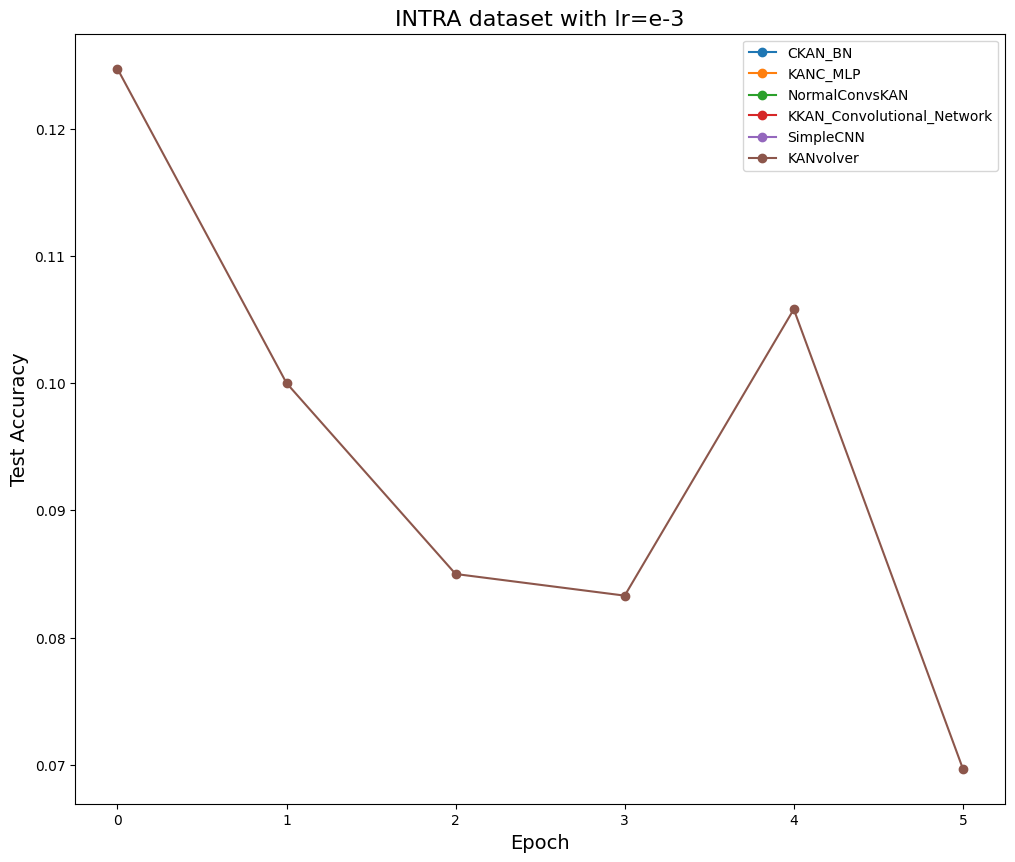

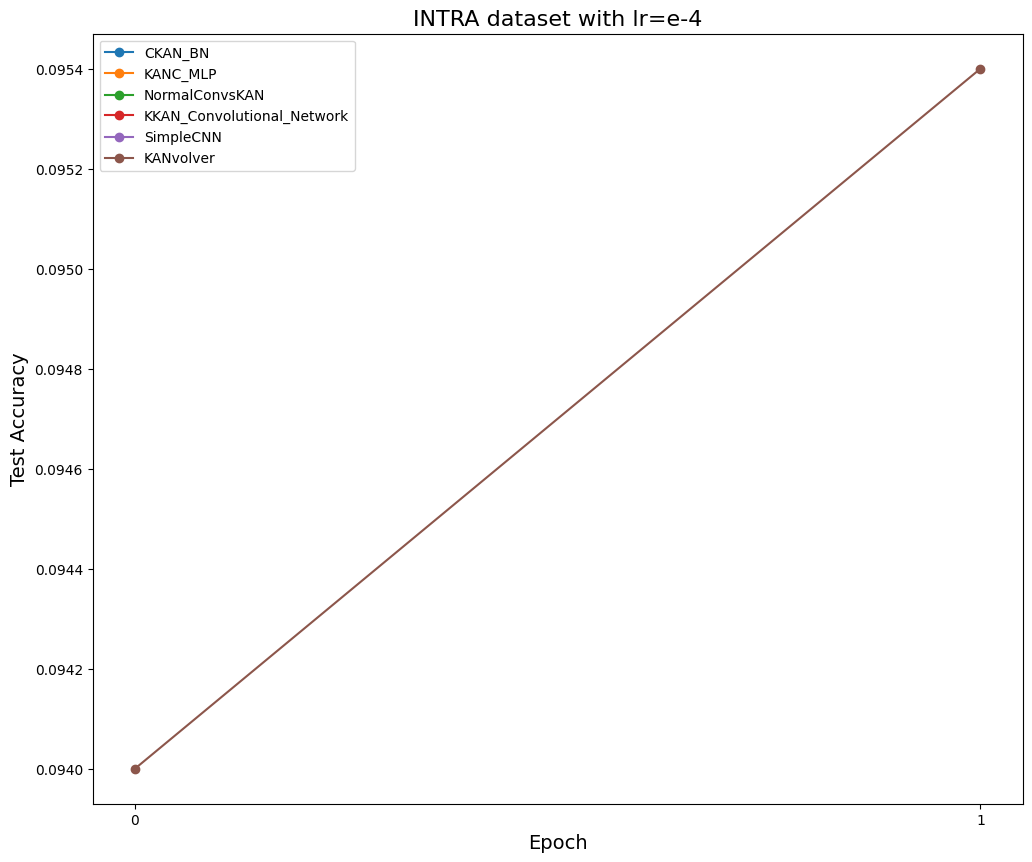

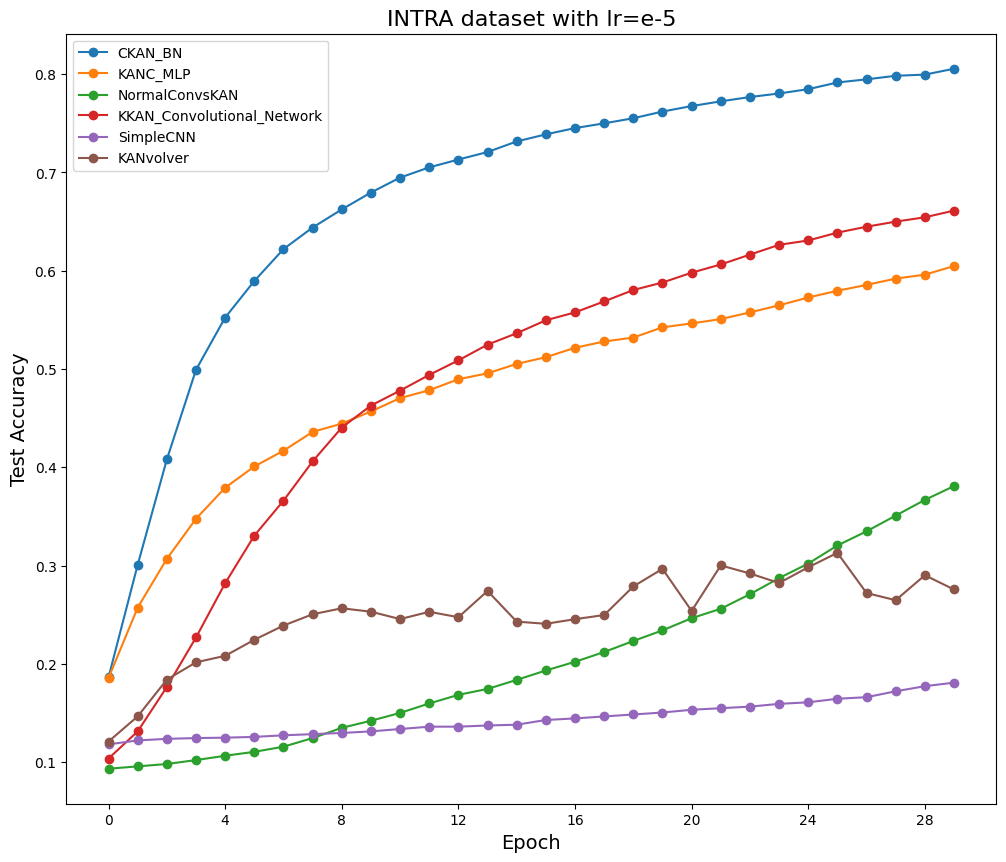

In [29]:
models = [MLP(), KAN_small(),
          CKAN_BN(), KANC_MLP(), NormalConvsKAN(),
          KKAN_Convolutional_Network(), SimpleCNN(),KANvolver()]
for lr in [1e-3,1e-4,1e-5]:
    fig, ax = plt.subplots()
    batches = [
        0,
        5923,
        6742,
        5958,
        6131,
        5842,
        5421,
        5918,
        6265,
        5851,
        # 5949,
    ]
    granularity = 1
    for name in list(map(lambda e: e.__class__.__name__, models[2:])):
        stats = EpochStat.loadModelStats(name, dir='checkpoint_intra/stats/', subdir=f'lr_{round(math.log10(lr))}/')
        ax.plot(list(map(lambda e: e.get_accuracy(), stats))[:], label=name, marker='o')
        # ax.plot(list(map(lambda e: e.train_accuracies, stats))[0][::granularity], label=name)
    plt.legend()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    # ax.set_xticks([x // 64 // granularity for x in itertools.accumulate(batches)])
    # ax.set_xticklabels(range(10))
    # plt.vlines(x=[x // 64 // granularity for x in itertools.accumulate(batches)], ymin=0, ymax=1, colors='black',
    #            alpha=0.65, linestyles='dashed')
    # plt.xlabel('Train Digits Batches', fontdict={'fontsize': 14})
    # plt.ylabel('Train batch Loss', fontdict={'fontsize': 14})
    # plt.title('Train batch loss spikes show up when a new digit is submitted', fontdict={'fontsize': 16})
    plt.xlabel('Epoch', fontdict={'fontsize': 14})
    plt.ylabel('Test Accuracy', fontdict={'fontsize': 14})
    plt.title(f'INTRA dataset with lr=e{round(math.log10(lr))}', fontdict={'fontsize': 16})
    # plt.vlines(x=range(0, 30,6)[1:], ymin=0, ymax=0.5, colors='black',alpha=0.65, linestyles='dashed')
    fig.set_size_inches(12, 10)
    plt.show()

## CONFUSION MATRICES PLOTTING

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

models = [MLP(), KAN_small(),
          CKAN_BN(), KANC_MLP(), NormalConvsKAN(), ConvNet(),
          KKAN_Convolutional_Network(), SimpleCNN()]
plt.rc('font', size=18)
for name in list(map(lambda e: e.__class__.__name__, models[:2])):
    stats = EpochStat.loadModelStats(name, dir='checkpoint_inter/stats/', subdir='')
    for stat in stats[:]:
        cm = confusion_matrix(stat.labels, stat.predictions, labels=range(10))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
        disp.plot()
        fig = disp.ax_.get_figure()
        fig.set_figwidth(8)
        fig.set_figheight(8)
        plt.figtext(0.445, 0.85, f'{name.replace("KAN_small", "KAN")} Epoch: {stat.epoch}', ha='center', fontsize=22)
        fig.savefig(f'png/inter/lr_-6/{name} ep{stat.epoch}.png')